In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import pathlib
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import os

Using TensorFlow backend.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
conv_base = ResNet50(weights='imagenet', 
                     include_top=False,
                     input_shape=(224, 224, 3))
conv_base.summary()

/home/gxty/.conda/envs/keras_tensorflow_conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [5]:
flat_layer = layers.Flatten()(conv_base.output)
predictions = layers.Dense(38, activation='softmax', kernel_initializer='he_normal')(flat_layer)
model = models.Model(inputs=conv_base.input, outputs=predictions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [6]:
def get_train_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_train_for_keras = original_data.loc[original_data['is_valid'] == False, ['relative_path', 'label']]
    df_train_for_keras = df_train_for_keras.astype(str)
    return df_train_for_keras

def get_val_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_val_for_keras = original_data.loc[original_data['is_valid'] == True, ['relative_path', 'label']]
    df_val_for_keras = df_val_for_keras.astype(str)
    return df_val_for_keras

def get_test_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_test_for_keras = original_data[['relative_path', 'label']]
    df_test_for_keras = df_test_for_keras.astype(str)
    return df_test_for_keras

df_train_for_keras = get_train_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv")
print(df_train_for_keras[:5])

df_val_for_keras = get_val_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv")
print(df_val_for_keras[:5])

df_test_for_keras = get_test_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "test_group.csv")
print(df_test_for_keras[:5])

directory = str(pathlib.Path.cwd()) + "/raw_datasets/images/plantVillage"

                                       relative_path label
0  Orange___Haunglongbing_(Citrus_greening)/UF.Ci...    15
1  Orange___Haunglongbing_(Citrus_greening)/CREC_...    15
2         Squash___Powdery_mildew/MD_Powd.M 1073.JPG    25
3  Cherry_(including_sour)___Powdery_mildew/FREC_...     5
4                   Soybean___healthy/RS_HL 5527.JPG    24
                                           relative_path label
38061  Orange___Haunglongbing_(Citrus_greening)/CREC_...    15
38062  Orange___Haunglongbing_(Citrus_greening)/CREC_...    15
38063  Cherry_(including_sour)___Powdery_mildew/FREC_...     5
38064           Tomato___Late_blight/GHLB2 Leaf 9017.JPG    30
38065                 Grape___healthy/Mt.N.V_HL 6114.JPG    14
                                       relative_path label
0       Peach___Bacterial_spot/Rutg._Bact.S 1180.JPG    16
1          Potato___Early_blight/RS_Early.B 8300.JPG    20
2   Grape___Esca_(Black_Measles)/FAM_B.Msls 4481.JPG    12
3   Grape___Esca_(Black_Measles)

In [7]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rescale=1./255,
                                   rotation_range=25,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_dataframe(df_train_for_keras,
                                                    directory=directory,
                                                    x_col='relative_path',
                                                    y_col='label',
                                                    target_size=(224, 224),
                                                    batch_size=64,
                                                    drop_duplicates=False)
val_generator = val_datagen.flow_from_dataframe(df_val_for_keras,
                                                directory=directory,
                                                x_col='relative_path',
                                                y_col='label',
                                                target_size=(224, 224),
                                                batch_size=64,
                                                shuffle=False,
                                                drop_duplicates=False)

Found 38061 images belonging to 38 classes.
Found 5274 images belonging to 38 classes.


In [9]:
conv_base.trainable = False

In [10]:
opt = optimizers.rmsprop(lr=1e-4, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=[metrics.categorical_accuracy])

history = model.fit_generator(train_generator,
                              steps_per_epoch=595,
                              epochs=5,
                              validation_data=val_generator,
                              validation_steps=83)

model.save(str(pathlib.Path.cwd()) + "/models/" + "resnet50_keras_stage_1_group.h5")

Epoch 1/5
595/595 [==============================] - 489s 822ms/step - loss: 0.2325 - categorical_accuracy: 0.9420 - val_loss: 0.2694 - val_categorical_accuracy: 0.9632
Epoch 2/5
595/595 [==============================] - 479s 805ms/step - loss: 0.0561 - categorical_accuracy: 0.9854 - val_loss: 0.2017 - val_categorical_accuracy: 0.9708
Epoch 3/5
595/595 [==============================] - 479s 806ms/step - loss: 0.0334 - categorical_accuracy: 0.9913 - val_loss: 0.0724 - val_categorical_accuracy: 0.9805
Epoch 4/5
595/595 [==============================] - 472s 793ms/step - loss: 0.0257 - categorical_accuracy: 0.9934 - val_loss: 0.1233 - val_categorical_accuracy: 0.9778
Epoch 5/5
595/595 [==============================] - 478s 803ms/step - loss: 0.0206 - categorical_accuracy: 0.9946 - val_loss: 0.2376 - val_categorical_accuracy: 0.9717


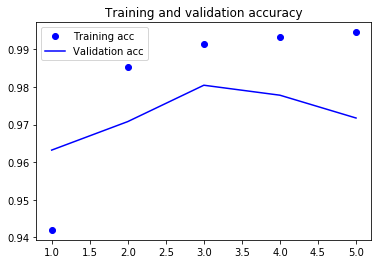

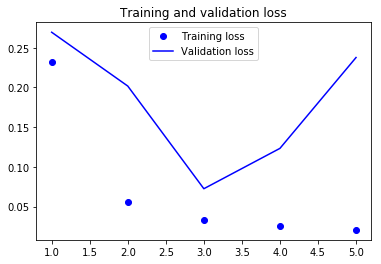

In [12]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [16]:
for each_layer in model.layers[:140]:
    each_layer.trainable = False
    
for each_layer in model.layers[140:]:
    each_layer.trainable = True

In [ ]:
opt = optimizers.rmsprop(lr=1e-5)
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=[metrics.categorical_accuracy])

history = model.fit_generator(train_generator,
                              steps_per_epoch=595,
                              epochs=30,
                              validation_data=val_generator,
                              validation_steps=83)

model.save(str(pathlib.Path.cwd()) + "/models/" + "resnet50_keras_stage_2_group.h5")

Epoch 1/30
595/595 [==============================] - 485s 815ms/step - loss: 0.0177 - categorical_accuracy: 0.9957 - val_loss: 0.0735 - val_categorical_accuracy: 0.9852
Epoch 2/30
595/595 [==============================] - 474s 796ms/step - loss: 0.0104 - categorical_accuracy: 0.9976 - val_loss: 0.0685 - val_categorical_accuracy: 0.9869
Epoch 3/30
595/595 [==============================] - 475s 798ms/step - loss: 0.0072 - categorical_accuracy: 0.9982 - val_loss: 0.0640 - val_categorical_accuracy: 0.9871
Epoch 4/30
595/595 [==============================] - 473s 795ms/step - loss: 0.0067 - categorical_accuracy: 0.9985 - val_loss: 0.0685 - val_categorical_accuracy: 0.9875
Epoch 5/30
595/595 [==============================] - 476s 800ms/step - loss: 0.0069 - categorical_accuracy: 0.9989 - val_loss: 0.0578 - val_categorical_accuracy: 0.9888
Epoch 6/30
595/595 [==============================] - 475s 798ms/step - loss: 0.0053 - categorical_accuracy: 0.9991 - val_loss: 0.0585 - val_categoric

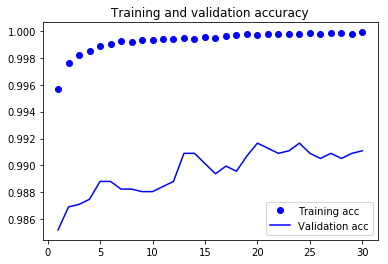

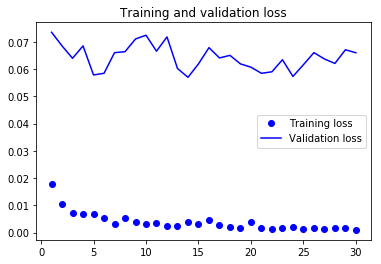

In [19]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()